<a href="https://www.kaggle.com/code/victortrigo/cnn-pneumonia?scriptVersionId=106381980" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Deep Learning for Pneumonia Diagnosis

Author: Victor Trigo

Pneumonia is an infection of the lung tissue, commonly found in children and adults over 65 years of age. The diagnosis of pneumonia primarily requires a chest x-ray and physical examinations. Improving our diagnostic skills is of great value to medicine. The dataset is a set of images of chest X-rays.

Next, will be development a Convolutional Neural Network to classify chest X-rays in 'pneumonia' or 'normal'.

## Libraries

In [1]:
import tensorflow as tf                                                                                              # Backend of Keras
from tensorflow.keras import models, optimizers, regularizers                                                        # Model components
from tensorflow.keras.models import Sequential, load_model                                                           #
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization    # Model layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator                                                  # Data Augmentation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping                                                # Checkpoint and Stop 

import matplotlib.pyplot as plt                                                                                      # Plots
import numpy as np                                                                                                   # Maths
import pandas as pd                                                                                                  # Data Frames

import cv2                                                                                                           # directory management tool
import os                                                                                                            #


import warnings                                                                                                      # Warning
warnings.filterwarnings("ignore")

## ETL

We will create a function called 'get_traning_data' that uses directory management tools ('os' and 'cv' libraries) to load the dataset.

The images of chest X-rays is loaded with 150 x 150 px dimension.

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')

OpenCV(4.5.4-dev) /tmp/pip-req-build-0culq997/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.4-dev) /tmp/pip-req-build-0culq997/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



The validation dataset of Kaggle have only 16 images.  Will be build a new validation dataset from trainig dataset.

For this will use a Bernoulli distribution to separate training dataset and validation datasets

In [4]:
l = np.random.binomial(1, 0.1, 5216)       # array of 0s and 1s in proportion 0.9 and 0.1 

x_train = []
y_train = []

x_val = []
y_val = []

for i in range(1,5216):
    if l[i] == 0:                         # if i = 0 add image to Train
            x_train.append(train[i][0])
            y_train.append(train[i][1])
    else:                                 # if i = 1 add image to Validation
            x_val.append(train[i][0])
            y_val.append(train[i][1])

Test dataset will be separate in feature and label.

In [5]:
x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature)   # Image
    y_test.append(label)     # 'pneumonia' or 'normal'

We standardize and implement reshape to images.

In [6]:
# divide the vectors by 255, so the numbers exist in the interval (0,1)
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [7]:
# reshape is: (for x_train) 4648 images of 150 x 150px and 1 color channel

x_train = x_train.reshape(x_train.shape[0], img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(x_val.shape[0], img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(x_test.shape[0], img_size, img_size, 1)
y_test = np.array(y_test)

In [8]:
# change variable type to categorical

y_train = tf.keras.utils.to_categorical(
    y_train, num_classes=2, dtype='float32'
)

y_val = tf.keras.utils.to_categorical(
    y_val, num_classes=2, dtype='float32'
)

y_test = tf.keras.utils.to_categorical(
    y_test, num_classes=2, dtype='float32'
)

In [9]:
# to check the changes
print('train data image: ', x_train.shape)
print('test data image: ', x_test.shape)
print('val data image: ', x_val.shape)

train data image:  (4718, 150, 150, 1)
test data image:  (624, 150, 150, 1)
val data image:  (497, 150, 150, 1)


In [10]:
print('train data image: ', y_train.shape)
print('test data image: ', y_test.shape)
print('val data image: ', y_val.shape)

train data image:  (4718, 2)
test data image:  (624, 2)
val data image:  (497, 2)


## Data Viz

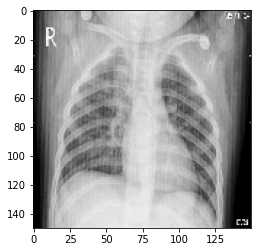

In [11]:
# chest x-ray with dimension 150 x 150px
plt.imshow(x_train[0], cmap='gray')

## Model

The model begins with Data Augmentation, where more images are generated from the existing ones, in order to reduce the imbalance in the data.

In [12]:
# Data Augmentation
datagen = ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True
)

In [13]:
# save the best model (as a function of val_accuracy) on the way to training
checkpoint = ModelCheckpoint('mejor_modelo.hdf5', 
                             verbose=1, 
                             save_best_only=True, 
                             monitor='val_accuracy'
)

In [14]:
# kernel size and learning rate size
base_filtros = 32
w_regularizers = 1e-4

In [15]:
# Arquitectura neuronal
model = Sequential()

model.add(Conv2D(base_filtros,   (3,3), padding='same', strides=(1,1), kernel_regularizer=regularizers.l2(w_regularizers), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4,4)))


model.add(Conv2D(2*base_filtros, (3,3), padding='same', strides=(1,1), kernel_regularizer=regularizers.l2(w_regularizers)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.summary()

2022-09-23 18:49:54.119425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 64)        2

2022-09-23 18:49:54.287285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 18:49:54.288925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 18:49:54.291266: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 18:49:54.292660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [16]:
# model compilation with categorical_crossentropy loss function and adam optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy']
)

In [17]:
# fit in 150 epochs using 40 images per epoch and saving the best model. Also using datagen function defined above
hist = model.fit(datagen.flow(x_train, y_train),
                 callbacks=[checkpoint],
                 steps_per_epoch=40,
                 epochs=150,
                 verbose=2,
                 validation_data=(datagen.flow(x_val, y_val))
)

2022-09-23 18:49:57.767025: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2022-09-23 18:49:59.598050: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


40/40 - 11s - loss: 0.7696 - accuracy: 0.8086 - val_loss: 0.5352 - val_accuracy: 0.7324

Epoch 00001: val_accuracy improved from -inf to 0.73239, saving model to mejor_modelo.hdf5
Epoch 2/150
40/40 - 4s - loss: 0.4572 - accuracy: 0.8836 - val_loss: 0.5382 - val_accuracy: 0.7324

Epoch 00002: val_accuracy did not improve from 0.73239
Epoch 3/150
40/40 - 3s - loss: 0.6207 - accuracy: 0.8680 - val_loss: 0.4555 - val_accuracy: 0.7525

Epoch 00003: val_accuracy improved from 0.73239 to 0.75252, saving model to mejor_modelo.hdf5
Epoch 4/150
40/40 - 3s - loss: 0.4144 - accuracy: 0.9031 - val_loss: 0.5183 - val_accuracy: 0.7384

Epoch 00004: val_accuracy did not improve from 0.75252
Epoch 5/150
40/40 - 3s - loss: 0.4105 - accuracy: 0.8945 - val_loss: 0.6712 - val_accuracy: 0.7364

Epoch 00005: val_accuracy did not improve from 0.75252
Epoch 6/150
40/40 - 3s - loss: 0.4141 - accuracy: 0.9017 - val_loss: 0.8820 - val_accuracy: 0.4648

Epoch 00006: val_accuracy did not improve from 0.75252
Epoch 

Este grafico muestra la evolucion del entrenamiento

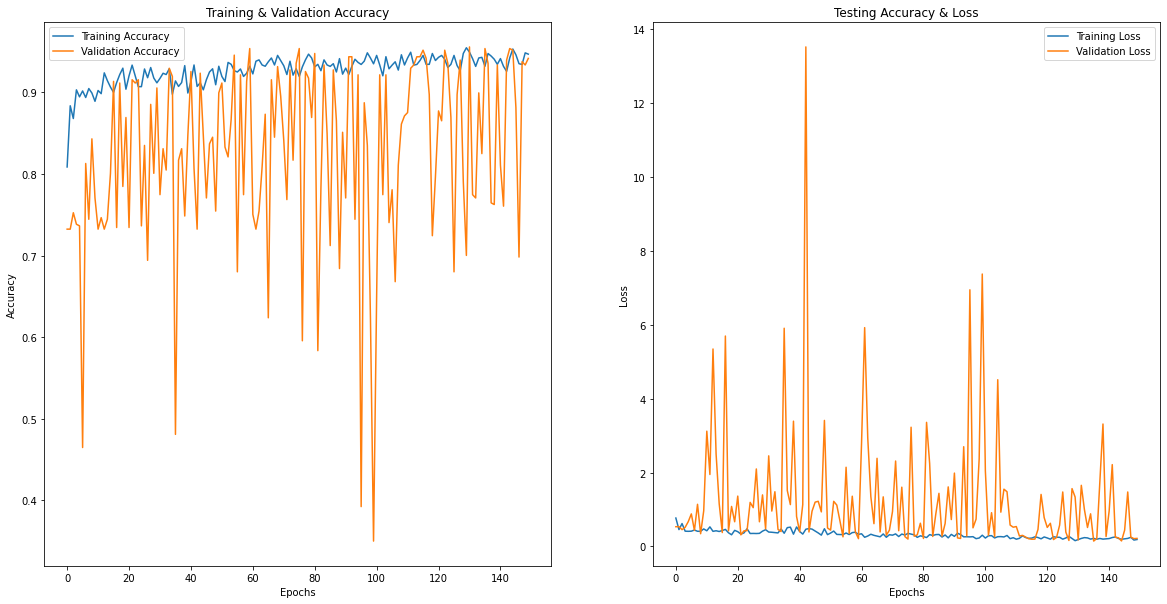

In [18]:
# training graph
epochs = [i for i in range(150)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs, hist.history['accuracy'],     label='Training Accuracy')
ax[0].plot(epochs, hist.history['val_accuracy'], label= 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, hist.history['loss'],     label = 'Training Loss')
ax[1].plot(epochs, hist.history['val_loss'], label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

We can also see that the model saved in checkpoint has better performance than the resulting model at the end of training.

In [19]:
# evaluation of the trained model
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 9ms/step - loss: 0.6238 - accuracy: 0.8301
Loss of the model is -  0.6238404512405396
20/20 [==============================] - 0s 6ms/step - loss: 0.6238 - accuracy: 0.8301
Accuracy of the model is -  83.01281929016113 %


In [20]:
# evaluation of the best model in training (checkpoint model)
model2 = load_model('./mejor_modelo.hdf5')
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 6ms/step - loss: 0.6460 - accuracy: 0.8478
Loss of the model is -  0.6459867358207703
20/20 [==============================] - 0s 6ms/step - loss: 0.6460 - accuracy: 0.8478
Accuracy of the model is -  84.77563858032227 %


We get a clearer view of this by examining the Confusion Matrix

In [21]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


(624,)
(624,)


<Figure size 432x288 with 0 Axes>

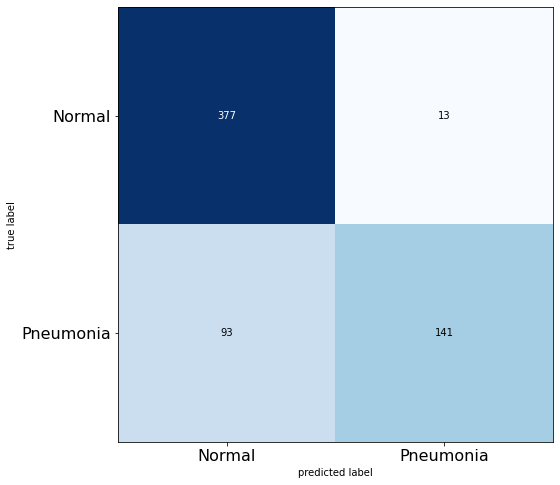

In [22]:
# Confusion Matrix to trained model
preds = model.predict(x_test, batch_size=16)
preds = np.argmax(preds, axis=-1)

orig_test_labels = np.argmax(y_test, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

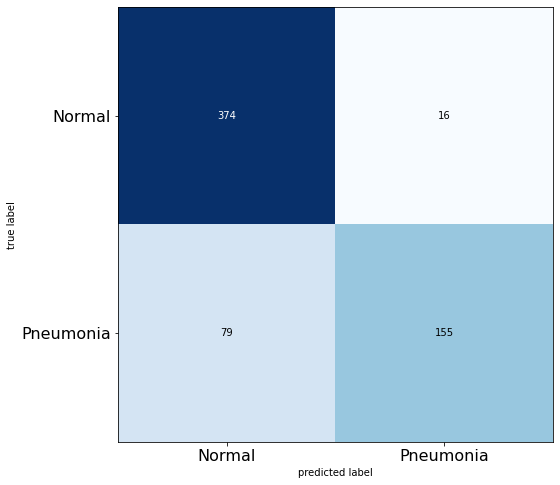

In [23]:
# Confusion Matrix to checkpoint model
preds = model2.predict(x_test, batch_size=16)
preds = np.argmax(preds, axis=-1)

orig_test_labels = np.argmax(y_test, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

Here we can obtain the following metrics:

- accuracy: 0.873
- recall: 0.959
- especificidad: 0.731
- presición: 0.856
- valor predicho negativo: 0.914

The specificity is the lowest value obtained, which indicates the many errors that the algorithm makes when trying to classify pneumonia as such.